# 데이터 전처리 - 결측치 다루기
* [Missing data - Wikipedia](https://en.wikipedia.org/wiki/Missing_data)
* 예제 데이터 다운로드 : https://www.kaggle.com/c/titanic/data

In [1]:
import pandas as pd
import numpy as np
import missingno as msno # 누락 된 데이터를 시각화 해주기 위해
import seaborn as sns

import sys
print(sys.version)
print(pd.__version__)
print(np.__version__)
print(msno.__version__)

3.6.1 (v3.6.1:69c0db5050, Mar 21 2017, 01:21:04) 
[GCC 4.2.1 (Apple Inc. build 5666) (dot 3)]
0.21.0
1.14.0
0.3.5


In [2]:
# 판다스를 통해 데이터를 로드해 온다.
# 여기에서는 캐글의 타이타닉 데이터를 사용한다. 
# 데이터 다운로드 : https://www.kaggle.com/c/titanic/data 
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

print(train.shape)
print(test.shape)

(891, 12)
(418, 11)


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


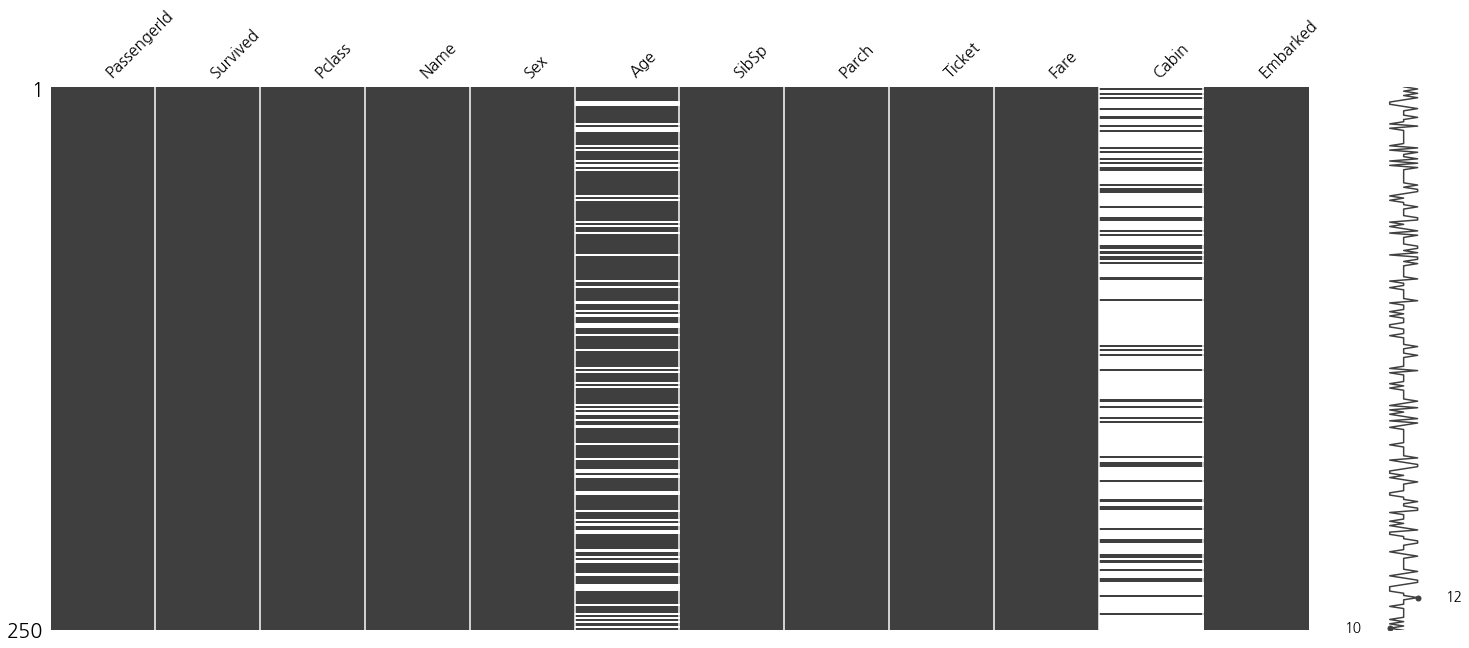

In [5]:
# 결측치를 시각화
%matplotlib inline
train = train.replace("nan", np.nan)
msno.matrix(train.sample(250))

In [6]:
# null 값 여부를 조회해 볼 수 있다.
train.isnull().head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,False,False,False,False,False,False,False,False,False,False,True,False
1,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,True,False
3,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,True,False


In [7]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [8]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

### 1. 중간값이나 최빈값으로 채워줌

In [9]:
train_mean = train.copy(deep = True)
test_mean = test.copy(deep = True)

In [10]:
train_mean.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
train['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [12]:
train['Ticket'].value_counts().head(7)

1601        7
CA. 2343    7
347082      7
CA 2144     6
3101295     6
347088      6
382652      5
Name: Ticket, dtype: int64

In [13]:
train['Ticket'].value_counts().tail(7)

347063             1
9234               1
A.5. 11206         1
31418              1
367232             1
SC/PARIS 2149      1
S.C./A.4. 23567    1
Name: Ticket, dtype: int64

In [14]:
# 정규표현식으로 티켓번호를 추출해 낸다.
# (\d{2,})에서 \d는 숫자를 의미하며, {2,}는 글자 수를 의미한다.
# 그래서 extract.('(\d{2,})')는 2자리 수 이상의 숫자를 추출하라는 의미이다.
train_mean['TicketNumber'] = train['Ticket'].str.extract('(\d{2,})', expand = True)
train_mean['TicketNumber'] = train_mean['TicketNumber'].apply(pd.to_numeric)

test_mean['TicketNumber'] = test['Ticket'].str.extract('(\d{2,})', expand = True)
test_mean['TicketNumber'] = test_mean['TicketNumber'].apply(pd.to_numeric)

In [15]:
train_mean['TicketNumber'].head()
test_mean['TicketNumber'].head()

0     330911.0
1     363272.0
2     240276.0
3     315154.0
4    3101298.0
Name: TicketNumber, dtype: float64

In [16]:
def data_fillna(dataset):
    # 중간값으로 누락된 나이 데이터를 채워준다.
    dataset['Age'].fillna(dataset['Age'].median(), inplace = True)

    # 최빈값(가장 자주 나오는 값)으로 누락된 승선위치를 채워준다.
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace = True)

    # 중간값으로 누락된 요금을 채워준다.
    dataset['Fare'].fillna(dataset['Fare'].median(), inplace = True)
    
    # 중간값으로 티켓 번호를 채워준다.
    dataset['TicketNumber'].fillna(dataset['TicketNumber'].median(), inplace=True)

In [17]:
data_fillna(train_mean)
data_fillna(test_mean)

In [18]:
print(train.isnull().sum())
print('-' * 20)
print(train_mean.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
--------------------
PassengerId       0
Survived          0
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin           687
Embarked          0
TicketNumber      0
dtype: int64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x113453dd8>]],
      dtype=object)

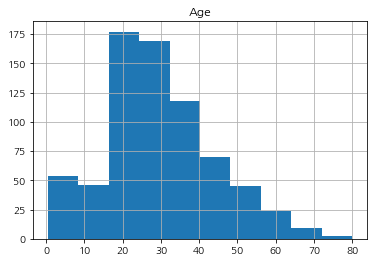

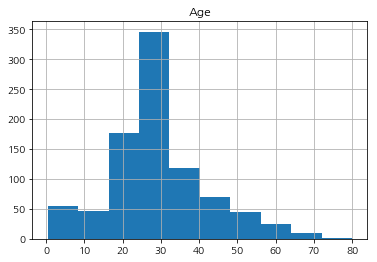

In [19]:
# 판다스의 시각화 툴을 사용해서 히스토그램 그래프를 그려본다.
# 중간값으로 채워주기 전 나이 데이터
train.hist(['Age'])
# 중간값으로 채워준 후의 나이 데이터
# 중간값이 눈에 띄게 늘어났다.
train_mean.hist(['Age'])

### 2. 사이킷런의 Imputer 를 사용

In [20]:
train_imputer = train.copy()
test_imputer = test.copy()

In [21]:
train_imputer['Age'][:5]

0    22.0
1    38.0
2    26.0
3    35.0
4    35.0
Name: Age, dtype: float64

#### Imputer를 사용해 보기에 앞서 shape와 reshape를 이해하고 넘어간다.

In [22]:
# 벡터 데이터의 형태를 출력해 본다.
print(train_imputer['Age'].values.shape)
# reshape(-1,1)를 사용해 벡터 데이터를 행렬 데이터로 변환해 준다.
print(train_imputer['Age'].values.reshape(-1,1).shape)

(891,)
(891, 1)


In [23]:
from sklearn.preprocessing import Imputer

# 결측치를 보완해 준다.
def nan_padding(data, columns):
    for column in columns:
        imputer = Imputer()
        data[column] = imputer.fit_transform(data[column].values.reshape(-1,1))
    return data


nan_columns = ['Age', 'SibSp', 'Parch', 'Fare']

train_imputer = nan_padding(train_imputer, nan_columns)
test_imputer = nan_padding(test_imputer, nan_columns)

In [24]:
print(train.isnull().sum())
print('-' * 20)
print(train_imputer.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
--------------------
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [25]:
train_imputer[nan_columns].head()

,Age,SibSp,Parch,Fare
0,22.0,1.0,0.0,7.2500
1,38.0,1.0,0.0,71.2833
2,26.0,0.0,0.0,7.9250
3,35.0,1.0,0.0,53.1000
4,35.0,0.0,0.0,8.0500


### 3. 다른 컬럼 정보를 사용해서 결측치를 예측

In [26]:
train_cp = train.copy()
test_cp = test.copy()

In [27]:
# 결측치가 있는 지 확인
train['Name'].isnull().sum()

0

In [28]:
# 일부의 데이터만 찍어보았지만 모든 데이터가 콤마(,)와 마침표(.)가 들어가 있다.
# 여기에서 콤마 뒤의 데이터가 호칭이며 Miss, Ms, Mrs 등으로 나이를 추측해 볼 수 있다.
train['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [29]:
# 이름에서 Title 항목만 떼어낸다.
# 콤마로 분리를 하고 분리된 두 번째 데이터의 첫번째 항목을 가져온다.
train['Title'] = train['Name'].str.split(
    ", ", expand=True)[1].str.split(".", expand=True)[0]
train['Title'].head()

test['Title'] = test['Name'].str.split(
    ", ", expand=True)[1].str.split(".", expand=True)[0]
test['Title'].head()

0     Mr
1    Mrs
2     Mr
3     Mr
4    Mrs
Name: Title, dtype: object

In [30]:
# 호칭의 갯수를 알아본다.
# Don은 스페인에서 세례명의 존칭 혹은 귀인을 뜻한다고 한다.
# Capt 또한 대위 또는 대령을 뜻한다.
train['Title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Major             2
Mlle              2
Col               2
Lady              1
Don               1
Ms                1
Sir               1
Capt              1
Jonkheer          1
the Countess      1
Mme               1
Name: Title, dtype: int64

In [31]:
train.query("Title in ('Dona', 'Lady', 'the Countess')")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
556,557,1,1,"Duff Gordon, Lady. (Lucille Christiana Sutherl...",female,48.0,1,0,11755,39.6,A16,C,Lady
759,760,1,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",female,33.0,0,0,110152,86.5,B77,S,the Countess


In [32]:
# 결혼한 여성 관련 호칭은 Mrs로 분류
train.loc[train['Title'].isin(['Dona', 'Lady', 'the Countess', 'Mme', 'Mlle']), 'Title'] = 'Ms'
train['Title'].value_counts()

test.loc[test['Title'].isin(['Dona', 'Lady', 'the Countess', 'Mme', 'Mlle']), 'Title'] = 'Ms'

In [33]:
train.loc[train['Title'].isin(['Don', 'Sir', 'Capt', 'Col', 'Major', 'Master', 'Rev', 'Dr', 'Jonkheer']), 'Title'] = 'Mr'
train['Title'].value_counts()

test.loc[test['Title'].isin(['Don', 'Sir', 'Capt', 'Col', 'Major', 'Master', 'Rev', 'Dr', 'Jonkheer']), 'Title'] = 'Mr'

In [34]:
train_rf = train.copy()
test_rf = test.copy()

In [35]:
train_rf.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [36]:
train_rf['FamilySize'] = train_rf['SibSp'] + train_rf['Parch']+1
test_rf['FamilySize'] = test_rf['SibSp'] + test_rf['Parch']+1
print(train_rf['FamilySize'].value_counts())

1     537
2     161
3     102
4      29
6      22
5      15
7      12
11      7
8       6
Name: FamilySize, dtype: int64


In [37]:
train_rf.loc[train_rf['FamilySize'] == 1, 'FsizeD'] = 'singleton'
train_rf.loc[(train_rf['FamilySize'] > 1)  &  (train_rf['FamilySize'] < 5) , 'FsizeD'] = 'small'
train_rf.loc[train_rf['FamilySize'] >4, 'FsizeD'] = 'large'

test_rf.loc[test_rf['FamilySize'] == 1, 'FsizeD'] = 'singleton'
test_rf.loc[(test_rf['FamilySize'] >1) & (test_rf['FamilySize'] <5) , 'FsizeD'] = 'small'
test_rf.loc[test_rf['FamilySize'] >4, 'FsizeD'] = 'large'
print(train_rf['FsizeD'].unique())
print(train_rf['FsizeD'].value_counts())

['small' 'singleton' 'large']
singleton    537
small        292
large         62
Name: FsizeD, dtype: int64


[okay, good, short, long]
Categories (4, object): [short < okay < good < long]


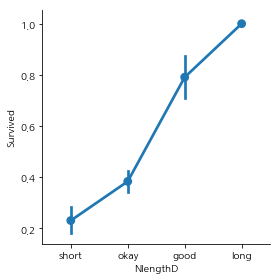

In [38]:
train_rf["NameLength"] = train["Name"].apply(lambda x: len(x))
test_rf["NameLength"] = test["Name"].apply(lambda x: len(x))

bins = [0, 20, 40, 57, 85]
group_names = ['short', 'okay', 'good', 'long']
train_rf['NlengthD'] = pd.cut(train_rf['NameLength'], bins, labels=group_names)
test_rf['NlengthD'] = pd.cut(test_rf['NameLength'], bins, labels=group_names)

sns.factorplot(x="NlengthD", y="Survived", data=train_rf)
print(train_rf["NlengthD"].unique())

In [39]:
train_rf['Deck'] = train_rf.Cabin.str[0]
test_rf['Deck'] = test_rf.Cabin.str[0]
train_rf['Deck'].unique() # 0 is for null values

array([nan, 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [40]:
def dummy_data(data, columns):
    for column in columns:
        data = pd.concat([data, pd.get_dummies(data[column], prefix = column)], axis=1)
        data = data.drop(column, axis=1)
    return data

def drop_data(data, columns):
    for column in columns:
        data = data.drop(column, axis=1)
    return data

In [41]:
dummy_columns = ['Sex', 'Pclass', 'Embarked', 'Deck', 'Title']
train_rf = dummy_data(train_rf, dummy_columns)
test_rf = dummy_data(test_rf, dummy_columns)

drop_columns = ['Name', 'Ticket', 'Cabin']
train_rf = drop_data(train_rf, drop_columns)
test_rf = drop_data(test_rf, drop_columns)

In [44]:
# https://www.kaggle.com/poonaml/titanic-survival-prediction-end-to-end-ml-pipeline
from sklearn.ensemble import RandomForestRegressor

def fill_missing_age(df):
    
#     #Feature set
#     age_df = df[['Age','Embarked','Fare', 'Parch', 'SibSp',
#                  'FamilySize', 'FsizeD','NameLength','NlengthD']]
    age_df = df
    # Split sets into train and test
    train  = age_df.loc[ (df.Age.notnull()) ]# known Age values
    test = age_df.loc[ (df.Age.isnull()) ]# null Ages
    
    # All age values are stored in a target array
    y = train.values[:, 0]
    
    # All the other values are stored in the feature array
    X = train.values[:, 1::]
    
    # Create and fit a model
    rtr = RandomForestRegressor(n_estimators=2000, n_jobs=-1)
    rtr.fit(X, y)
    
    # Use the fitted model to predict the missing values
    predictedAges = rtr.predict(test.values[:, 1::])
    
    # Assign those predictions to the full data set
    df.loc[ (df.Age.isnull()), 'Age' ] = predictedAges 
    
    return df

In [45]:
# train_rf = fill_missing_age(train_rf)

ValueError: could not convert string to float: 'short'

참고 : 
* https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy
* https://www.kaggle.com/poonaml/titanic-survival-prediction-end-to-end-ml-pipeline